## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [34]:
df = pd.read_csv('ethereum.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Close')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Open'].values.reshape(-1, 1)

df

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337
...,...
2022-05-28,1.72467
2022-05-29,1.79225
2022-05-30,1.81356


# Chuẩn hóa dữ liệu

In [35]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = arima_sc.fit_transform(df_close)
df_scaled

,Open
Date,
2020-06-01,-1.394670
2020-06-02,-1.382460
2020-06-03,-1.390075
2020-06-04,-1.385081
2020-06-05,-1.385955
...,...
2022-05-28,-0.270140
2022-05-29,-0.219234
2022-05-30,-0.203182


# Vẽ đồ thị

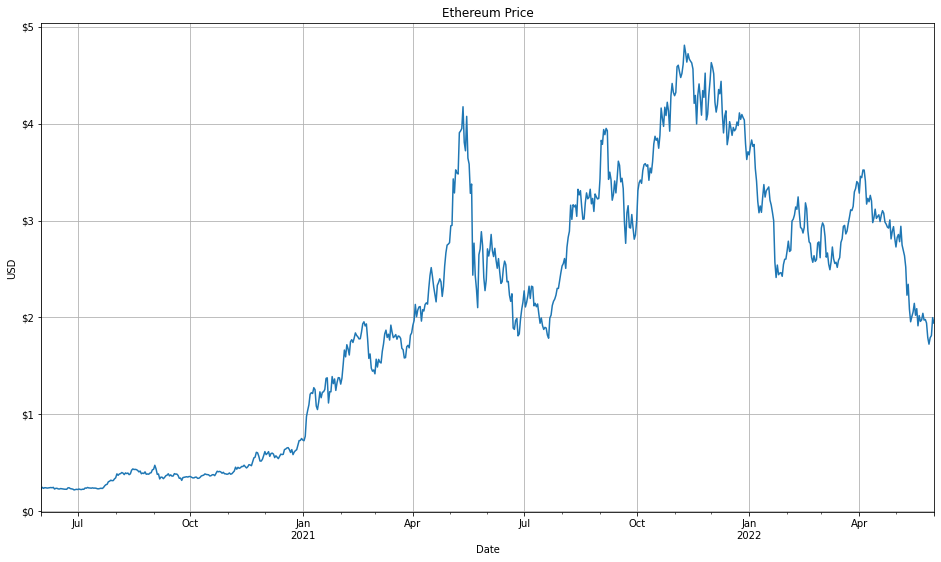

In [36]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Ethereum Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [37]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.9)], df_scaled[(int)(len(df_scaled) * 0.9):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.9):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657, 1)
test shape:  (74, 1)


# Hàm kiểm định chuỗi dừng

In [38]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [39]:
adf_test(train['Open'],'Ethereum Price')

Augmented Dickey-Fuller Test: Ethereum Price
ADF test statistic         -1.393911
p-value                     0.585192
Number of lags used         6.000000
Number of observations    650.000000
critical value (1%)        -3.440450
critical value (5%)        -2.865997
critical value (10%)       -2.569143
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

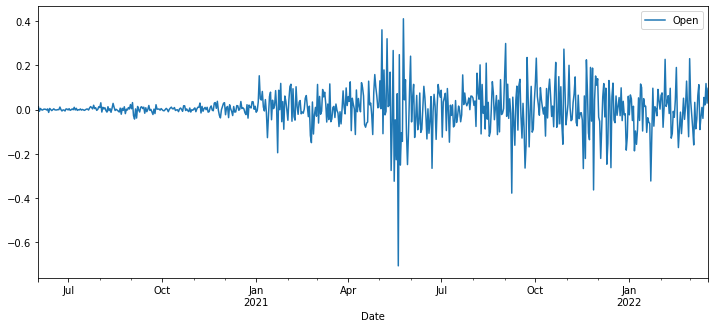

In [40]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [41]:
adf_test(diff_1, 'Ethereum Price First Difference')

Augmented Dickey-Fuller Test: Ethereum Price First Difference
ADF test statistic       -9.815996e+00
p-value                   5.495867e-17
Number of lags used       5.000000e+00
Number of observations    6.500000e+02
critical value (1%)      -3.440450e+00
critical value (5%)      -2.865997e+00
critical value (10%)     -2.569143e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [42]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [43]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1284.882, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1278.122, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1281.562, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1281.419, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1279.357, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1277.931, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1277.613, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1275.806, Time=1.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1291.866, Time=1.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1279.440, Time=1.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1287.291, Time=2.05 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-1288.335, Time=1.86 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1283.221, Time=1.35 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1286.007, Time=1.94 sec
 ARIMA(2,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  657
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 652.623
Date:                Mon, 27 Jun 2022   AIC                          -1293.246
Time:                        00:31:09   BIC                          -1266.329
Sample:                             0   HQIC                         -1282.810
                                - 657                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8346      0.031    -59.684      0.000      -1.895      -1.774
ar.L2         -0.9137      0.029    -31.341      0.000      -0.971      -0.857
ma.L1          1.7723      0.040     44.111      0.000       1.694       1.851
ma.L2          0.7991      0.064     12.448      0.000       0.673       0.925
ma.L3         -0.0789      0.033     -2.390      0.017      -0.144      -0.014
sigma2         0.0080      0.000     32.209      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1328.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              37.61   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [44]:
pred = arima_model.predict(len(test))
pred


array([0.63411079, 0.645967  , 0.62626005, 0.65158079, 0.62313426,
       0.65218605, 0.62487983, 0.64843071, 0.63017431, 0.64214886,
       0.63686128, 0.63562082, 0.64272761, 0.6308232 , 0.64616918,
       0.62889292, 0.64656593, 0.6299287 , 0.64430323, 0.63313337,
       0.64049146, 0.63719825, 0.63651695, 0.64077574, 0.63358525,
       0.64288544, 0.63239351, 0.64314418, 0.63300769, 0.64178102,
       0.63494732, 0.63946816, 0.6374182 , 0.63704839, 0.63959981,
       0.63525699, 0.64089296, 0.63452139, 0.64106094, 0.63488532,
       0.64023981, 0.63605921, 0.6388365 , 0.63756111, 0.63736334,
       0.63889144, 0.63626876, 0.63968402, 0.63581482, 0.63979265,
       0.6360303 , 0.6392981 , 0.6367407 , 0.63844668, 0.63765359,
       0.63754985, 0.63846479, 0.63688107, 0.63895053, 0.636601  ,
       0.63902053, 0.63672847, 0.63872271, 0.63715837, 0.63820616,
       0.63771323, 0.6376602 , 0.63820786, 0.6372516 , 0.63850553,
       0.63707884, 0.63855049, 0.63715419, 0.63837117])

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [45]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

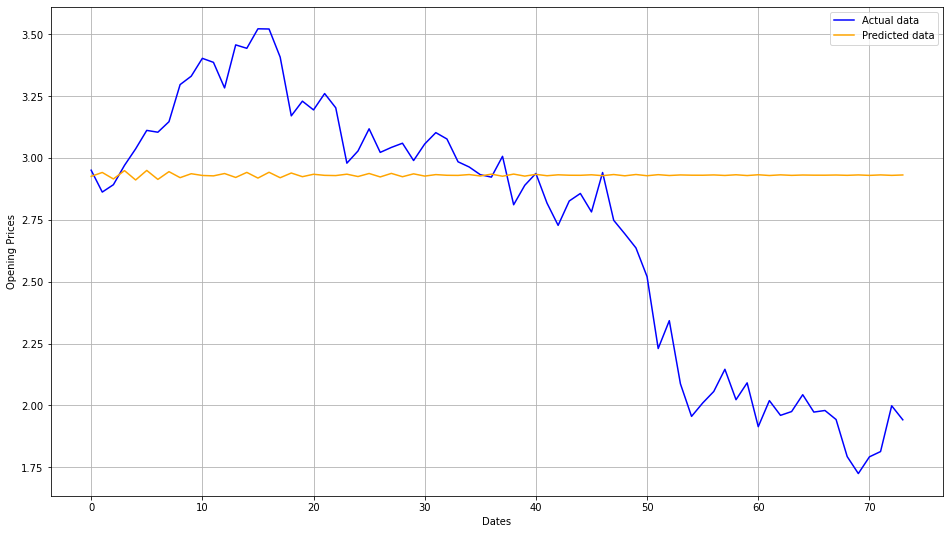

In [46]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [47]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.43
MAPE: 19.26%
MSE: 0.33
RMSE: 0.57
R2: -0.15


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [48]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-03-20,2.95003,2.925108,0.024922
2022-03-21,2.86166,2.940847,-0.079187
2022-03-22,2.89141,2.914685,-0.023275
2022-03-23,2.96964,2.948300,0.021340
2022-03-24,3.03618,2.910536,0.125644
...,...,...,...
2022-05-28,1.72467,2.930942,-1.206272
2022-05-29,1.79225,2.929048,-1.136798
2022-05-30,1.81356,2.931002,-1.117442


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [49]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2022-03-20,2.95003,2.925108,0.024922
2022-03-21,2.86166,2.940847,-0.079187
2022-03-22,2.89141,2.914685,-0.023275
2022-03-23,2.96964,2.948300,0.021340
2022-03-24,3.03618,2.910536,0.125644
...,...,...,...
2022-05-28,1.72467,2.930942,-1.206272
2022-05-29,1.79225,2.929048,-1.136798
2022-05-30,1.81356,2.931002,-1.117442


# Vẽ đồ thị thể hiện sai số

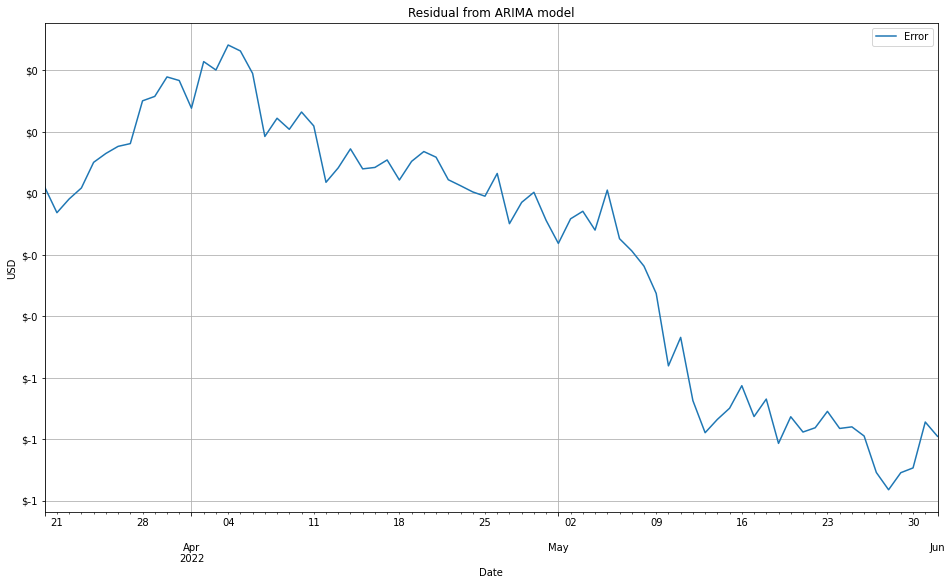

In [50]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [51]:
error = np.array(error)
error

array([[ 0.02492231],
       [-0.0791874 ],
       [-0.02327543],
       [ 0.02134002],
       [ 0.1256442 ],
       [ 0.16169651],
       [ 0.19057688],
       [ 0.20183191],
       [ 0.37584819],
       [ 0.39389138],
       [ 0.47310091],
       [ 0.45848768],
       [ 0.34578305],
       [ 0.53543675],
       [ 0.5012242 ],
       [ 0.6029793 ],
       [ 0.57870749],
       [ 0.48727425],
       [ 0.23094134],
       [ 0.30501989],
       [ 0.25996166],
       [ 0.33038356],
       [ 0.27368802],
       [ 0.04449426],
       [ 0.10323   ],
       [ 0.18045353],
       [ 0.09910209],
       [ 0.10491004],
       [ 0.13531673],
       [ 0.05375971],
       [ 0.12964178],
       [ 0.16957014],
       [ 0.14656157],
       [ 0.0549025 ],
       [ 0.03060537],
       [ 0.00527068],
       [-0.01208135],
       [ 0.08038722],
       [-0.12391435],
       [-0.03712592],
       [ 0.00376574],
       [-0.11055431],
       [-0.2041813 ],
       [-0.10403816],
       [-0.07341561],
       [-0

In [52]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (71, 3, 1)
y_train (71, 1)


In [53]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("ethereum_9_1.h5")

Epoch 1/300
3/3 [==============================] - 4s 9ms/step - loss: 0.3331
Epoch 2/300
3/3 [==============================] - 0s 8ms/step - loss: 0.3181
Epoch 3/300
3/3 [==============================] - 0s 0s/step - loss: 0.3067
Epoch 4/300
3/3 [==============================] - 0s 8ms/step - loss: 0.2962
Epoch 5/300
3/3 [==============================] - 0s 8ms/step - loss: 0.2830
Epoch 6/300
3/3 [==============================] - 0s 7ms/step - loss: 0.2699
Epoch 7/300
3/3 [==============================] - 0s 3ms/step - loss: 0.2570
Epoch 8/300
3/3 [==============================] - 0s 2ms/step - loss: 0.2417
Epoch 9/300
3/3 [==============================] - 0s 7ms/step - loss: 0.2259
Epoch 10/300
3/3 [==============================] - 0s 4ms/step - loss: 0.2043
Epoch 11/300
3/3 [==============================] - 0s 6ms/step - loss: 0.1839
Epoch 12/300
3/3 [==============================] - 0s 6ms/step - loss: 0.1604
Epoch 13/300
3/3 [==============================] - 0s 7ms/ste

In [54]:
model = load_model("ethereum_9_1.h5")
error_pred = model.predict(x_train)
error_pred

3/3 [==============================] - 1s 5ms/step


array([[-0.02552896],
       [-0.01419076],
       [ 0.07436553],
       [ 0.14296088],
       [ 0.19051799],
       [ 0.21106072],
       [ 0.28504637],
       [ 0.33701938],
       [ 0.39524704],
       [ 0.41124636],
       [ 0.37597662],
       [ 0.41799507],
       [ 0.43553156],
       [ 0.49177724],
       [ 0.50061196],
       [ 0.4741996 ],
       [ 0.35408443],
       [ 0.30807698],
       [ 0.27444884],
       [ 0.2993792 ],
       [ 0.28935033],
       [ 0.2017348 ],
       [ 0.14896752],
       [ 0.1492144 ],
       [ 0.15351236],
       [ 0.14720479],
       [ 0.14289606],
       [ 0.11923297],
       [ 0.13185064],
       [ 0.15558252],
       [ 0.17587377],
       [ 0.13911654],
       [ 0.09082769],
       [ 0.04452754],
       [ 0.01819003],
       [ 0.04750346],
       [-0.017986  ],
       [-0.03335065],
       [-0.04550445],
       [-0.0546512 ],
       [-0.1486272 ],
       [-0.19554573],
       [-0.16146912],
       [-0.1443762 ],
       [-0.07925485],
       [-0

In [55]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-03-20,2.95003,2.925108,0.024922,-0.025529
2022-03-21,2.86166,2.940847,-0.079187,-0.014191
2022-03-22,2.89141,2.914685,-0.023275,0.074366
2022-03-23,2.96964,2.948300,0.021340,0.142961
2022-03-24,3.03618,2.910536,0.125644,0.190518
...,...,...,...,...
2022-05-25,1.97940,2.929820,-0.950420,-1.016764
2022-05-26,1.94289,2.930547,-0.987657,-1.061617
2022-05-27,1.79319,2.929277,-1.136087,-1.068417


In [56]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2022-03-20,2.95003,2.925108,0.024922,-0.025529,2.899579
2022-03-21,2.86166,2.940847,-0.079187,-0.014191,2.926657
2022-03-22,2.89141,2.914685,-0.023275,0.074366,2.989051
2022-03-23,2.96964,2.948300,0.021340,0.142961,3.091261
2022-03-24,3.03618,2.910536,0.125644,0.190518,3.101054
...,...,...,...,...,...
2022-05-25,1.97940,2.929820,-0.950420,-1.016764,1.913056
2022-05-26,1.94289,2.930547,-0.987657,-1.061617,1.868929
2022-05-27,1.79319,2.929277,-1.136087,-1.068417,1.860860


# Vẽ đồ thị

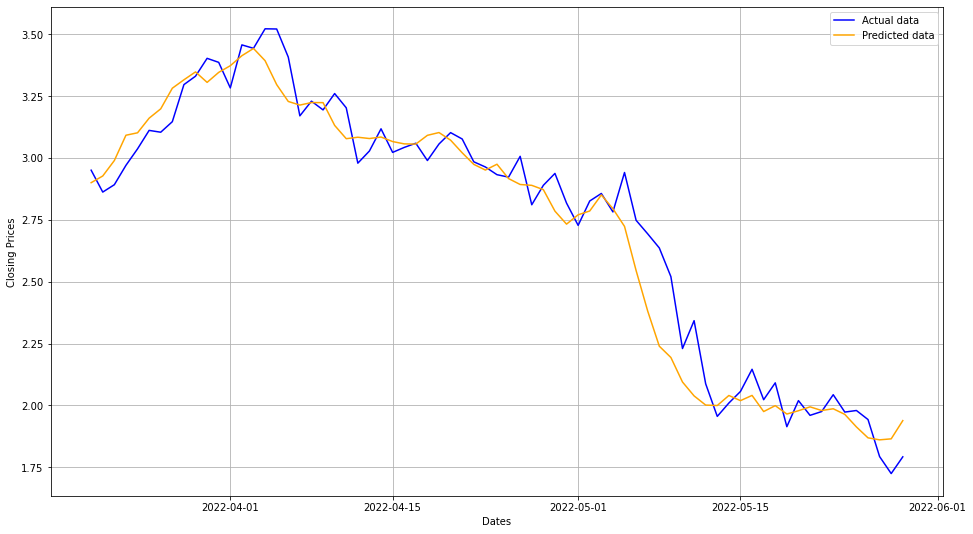

In [57]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [58]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.08
MAPE: 3.19%
MSE: 0.01
RMSE: 0.12
R2: 0.95


# Lấy 3 ngày cuối ra để dự báo

In [59]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -1.136087
2022-05-28   -1.206272
2022-05-29   -1.136798
Name: Error, dtype: float64

# Đưa về ma trận

In [60]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-1.13608727],
        [-1.20627191],
        [-1.13679792]]])

In [61]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 64ms/step


array([-1.0684174], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [62]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,1.79225,2.929048,-1.136798


In [63]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,1.79225,2.929048,-1.136798,1.86063


# Ghi ra file csv

In [64]:
df.to_csv("eth_processed_data_9_1.csv")
df_scaled.to_csv("eth_scaled_data_9_1.csv")
df_pred.to_csv("eth_ARIMA-PRED_9_1.csv")
df_lstm.to_csv("eth_LSTM_PRED_9_1.csv")
y_arima.to_csv("eth_Forecast_9_1.csv")